In [1]:
import os
import cv2
import numpy as np
import math
from PIL import Image

In [2]:
kRatio = 3

In [3]:
def to_images(file_path):
  import fitz
  doc = fitz.open(file_path)
  images = []
  for index in range(0, doc.page_count):
    page = doc.load_page(index)
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    images.append(img)
  return images

In [4]:
class Page:
  def __init__(self, master, image):
    self.master = master
    self.image = image
    gray = cv2.cvtColor(np.array(image.convert('RGB'))[:, :, ::-1].copy(), cv2.COLOR_BGR2GRAY)
    self.height, self.width = gray.shape

    self.thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(self.thresh, 8, cv2.CV_32S)
    (_, _, self.ccs, self.centroids) = output

  def compute_horizontal_projection(self, ratio=kRatio):
    hs = np.zeros(self.master.shape[1] + 1)

    def collect_horizontal_runlengths(x, y, w, h):
      for y_ in range(y, y + h):
        hs[y_] += np.count_nonzero(self.thresh[y_][x : x + w] == 255)

    for (x, y, w, h, _) in self.ccs:
      if w / h < ratio:
        continue
      collect_horizontal_runlengths(x, y, w, h)
    hs /= self.master.oligon_width
    return hs

  def filter_projection(self, fn):
    hs = fn()
    return hs

  def get_peaks(self, xs):
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(xs, height=0)

    peaks = peaks[np.where(xs[peaks] > 0.8)]
    new_peaks = []
    index = 0
    while index < len(peaks):
      ptr = index + 1
      argmax = index
      while ptr < len(peaks) and peaks[ptr] - peaks[index] <= self.master.oligon_width:
        if xs[peaks[ptr]] > xs[peaks[argmax]]:
          argmax = ptr
        ptr += 1
      new_peaks.append(peaks[argmax])
      index = ptr
    return np.array(new_peaks)
    # print(f'peaks={peaks}')

    # if len(peaks) == 1:
    #   return peaks

    # import kmeans1d
    # from sklearn.metrics import silhouette_score

    # # def is_valid(clusters, k):
    # #   for c in range(k):
    # #     tmp = xs[peaks[np.where(clusters == c)]]
    # #     if len(tmp) == 1:
    # #       continue
    # #     two_maxs = tmp[np.argpartition(tmp, -2)[-2:]]
    # #     if not (two_maxs[0] >= 2 * two_maxs[1]) and not (two_maxs[1] >= 2 * two_maxs):
    # #       return False
    # #   return True         

    # # TODO: improve kmeans1d, when applied to many `k`'s.
    # # TODO: check for cases when `k` = `n` is viable, e.g., check for the normalized variance to be lt `oligon_height`.
    # scores = []
    # for k in range(2, len(peaks)):
    #   clusters, _ = kmeans1d.cluster(peaks, k)
    #   score = silhouette_score(peaks.reshape(-1, 1), clusters)
    #   scores.append(score)
    #   # if is_valid(clusters, k):
    #   #   scores.append(score)
    #   # else:
    #   #   scores.append(0)

    # best_k = np.argmax(np.array(scores)) + 2

    # print(f'scores={scores}')

    # print(f'best_k={best_k}')

    # clusters, centroids = kmeans1d.cluster(peaks, best_k)
    # new_peak_indices = [-1] * (len(centroids))
    # for i in range(len(clusters)):
    #   c = clusters[i]
    #   if new_peak_indices[c] == -1:
    #     new_peak_indices[c] = i
    #   elif xs[peaks[i]] > xs[peaks[new_peak_indices[c]]]:
    #     new_peak_indices[c] = i
    # print(f'diff={np.diff(peaks[new_peak_indices])}')
    # print(f'var={np.var(np.diff(peaks[new_peak_indices]))}')
    return peaks[new_peak_indices]

  def compute_baselines(self):
    hs = self.filter_projection(self.compute_horizontal_projection)
    indices = self.get_peaks(hs)
    
    baselines = []
    for i in range(len(indices)):
      if not i:
        baselines.append(indices[i])
        continue
      assert len(baselines)

      # Far apart?
      if indices[i] - baselines[-1] > 4 * self.master.oligon_height:
        baselines.append(indices[i])
        continue
      
      # Check which one to take.
      if hs[baselines[-1]] > hs[indices[i]]:
        continue

      # Replace the last baseline.
      baselines[-1] = indices[i]
    return baselines

  def plot_horizontal_projection(self):
    import matplotlib.pyplot as plt
    f = plt.figure()
    f.set_figwidth(50)
    f.set_figheight(10)

    hs = self.filter_projection(self.compute_horizontal_projection)
    indices = self.get_peaks(hs)
    print(indices)
    for index in indices:
      plt.plot([index], [hs[index]], marker='o', markersize=15, color="red")
    plt.plot(hs, color='black')

  def compute_zero_ranges(self):
    self.thresh[self.thresh == 255] = 1
    hs = np.sum(self.thresh, axis=1)
    # num_occ_oligon = int(np.ceil(self.master.shape[0] / self.master.oligon_width))
    hs[hs < 1] = 0

    ranges = []
    def add_range(pos, t):
      if t == +1:
        ranges.append((pos, -1))
      else:
        assert len(ranges) is not None
        ranges[-1] = (ranges[-1][0], pos)

    inside = 0
    for i in range(len(hs)):
      if hs[i] > 0:
        if inside:
          add_range(i, -1)
          inside = 0
        continue
      if not inside:
        add_range(i, +1)
        inside = 1
    if not hs[-1]:
      add_range(len(hs), -1)
    return ranges   

  def plot_raw_horizontal_projection(self):
    import matplotlib.pyplot as plt
    f = plt.figure()
    f.set_figwidth(50)
    f.set_figheight(10)

    self.thresh[self.thresh == 255] = 1
    hs = np.sum(self.thresh, axis=1)
    num_occ_oligon = int(np.ceil(self.master.shape[0] / self.master.oligon_width))
    hs[hs < num_occ_oligon] = 0
    non_zero_indices = np.where(hs > 0)[0]
    test = np.zeros(hs.shape)
    test[non_zero_indices] = 1
    plt.plot(test, color='black')

  def plot_ranges(self):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(self.height / 10, self.width / 10))

    # Display the image
    ax.imshow(self.image)

    rs = self.compute_zero_ranges()
    for index, (b, e) in enumerate(rs):
      rect = patches.Rectangle((0, b), self.master.shape[0], e - b - 1, linewidth=2, edgecolor='purple', facecolor='purple', label=f'{index}')
      ax.add_patch(rect)
      rx, ry = rect.get_xy()
      cx = rx + rect.get_width() / 2.0
      cy = ry + rect.get_height() / 2.0
      ax.annotate(f'{index}', (cx, cy), color='green', weight='bold', fontsize=16, ha='center', va='center')
    plt.show()

  def plot_baselines(self):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(self.height / 10, self.width / 10))

    # Display the image
    ax.imshow(self.image)

    hs = self.compute_baselines()
    for index, h in enumerate(hs):
      rect = patches.Rectangle((0, h), self.master.shape[0], 2 * self.master.oligon_height, linewidth=2.5, edgecolor='purple', facecolor='none', label=f'{index}')
      ax.add_patch(rect)
      rx, ry = rect.get_xy()
      cx = rx + rect.get_width() / 2.0
      cy = ry + rect.get_height() / 2.0
      ax.annotate(f'{index}', (cx, cy), color='green', weight='bold', fontsize=16, ha='center', va='center')
    plt.show()

class Sheet:
  def __init__(self, file_path):
    images = to_images(file_path)
    self.pages = []
    for image in images:
      self.pages.append(Page(self, image))

    # Compute the shape.
    self.shape = (max(p.width for p in self.pages), max(p.height for p in self.pages))

    # Compute oligon parameters.
    self.oligon_width = self.compute_oligon_width()
    self.oligon_height = self.compute_oligon_height()

  def compute_oligon_width(self, ratio=kRatio):
    ws = [0] * (self.shape[0] + 1)
    for p in self.pages:
      for (_, _, w, h, _) in p.ccs:
        if w / h < ratio:
          continue
        ws[w] += 1
    total = sum(ws)
    curr = 0
    for i in range(1, self.shape[0] + 1):
      curr += ws[i]
      if curr >= total / 2:
        return i + 1
    return None

  def compute_oligon_height(self, ratio=kRatio):
    hs = [0] * (self.shape[1] + 1)
    
    def collect_vertical_runlengths(p, x, y, w, h):
      for x_ in range(x, x + w):
        sum = 0
        for y_ in range(y, y + h):
          bit = int(p.thresh[y_][x_] == 255)
          if bit == 1:
            sum += 1
          else:
            hs[sum] += 1
            sum = 0
        hs[sum] += 1

    for p in self.pages:
      for (x, y, w, h, _) in p.ccs:
        if w / h < ratio:
          continue
        collect_vertical_runlengths(p, x, y, w, h)
        
    max_freq = 0
    oligon_height = None
    for i in range(1, self.shape[1] + 1):
      if hs[i] > max_freq:
        max_freq = hs[i]
        oligon_height = i
    assert oligon_height is not None
    return oligon_height

  def __getitem__(self, key):
      return self.pages[key]

In [5]:
sheet = Sheet('samples/paraclis.pdf')

[ 63 123 183]


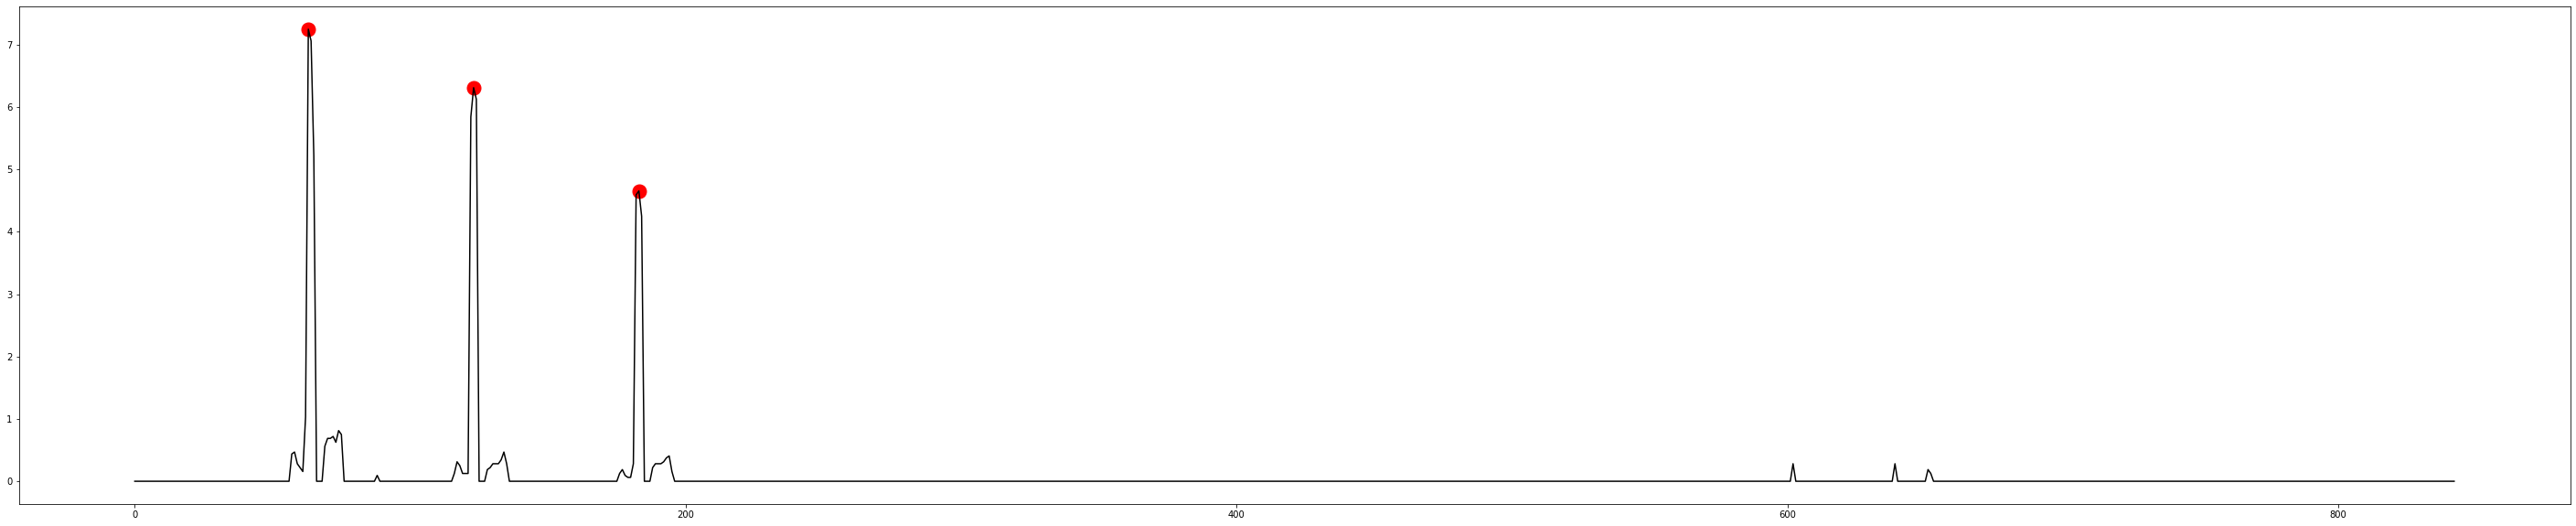

In [20]:
sheet[3].plot_horizontal_projection()

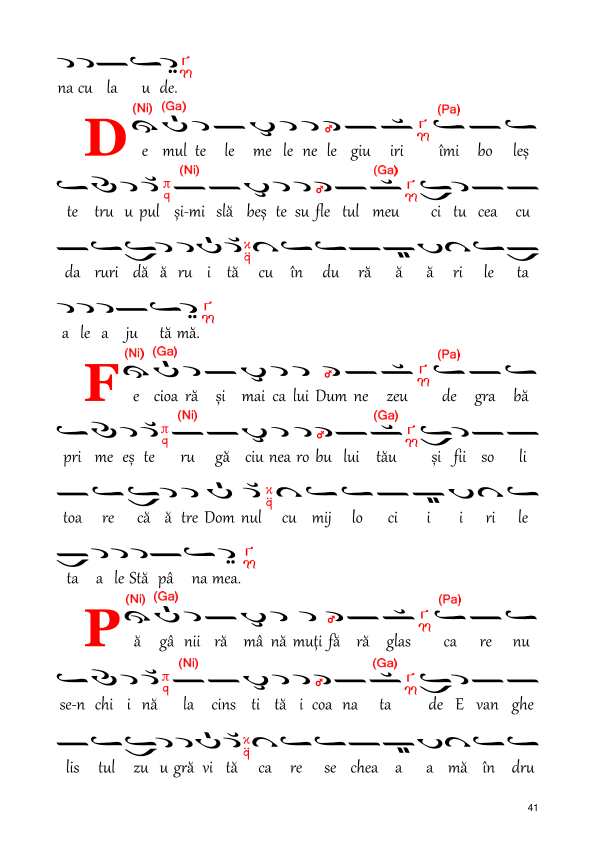

In [19]:
sheet[40].image

In [8]:
baselines = sheet[24].compute_baselines()
baselines

[63, 181, 224, 287, 351, 414, 476, 539, 603, 666, 729]

32
[ 63 181 224 287 351 414 476 539 603 666 729]


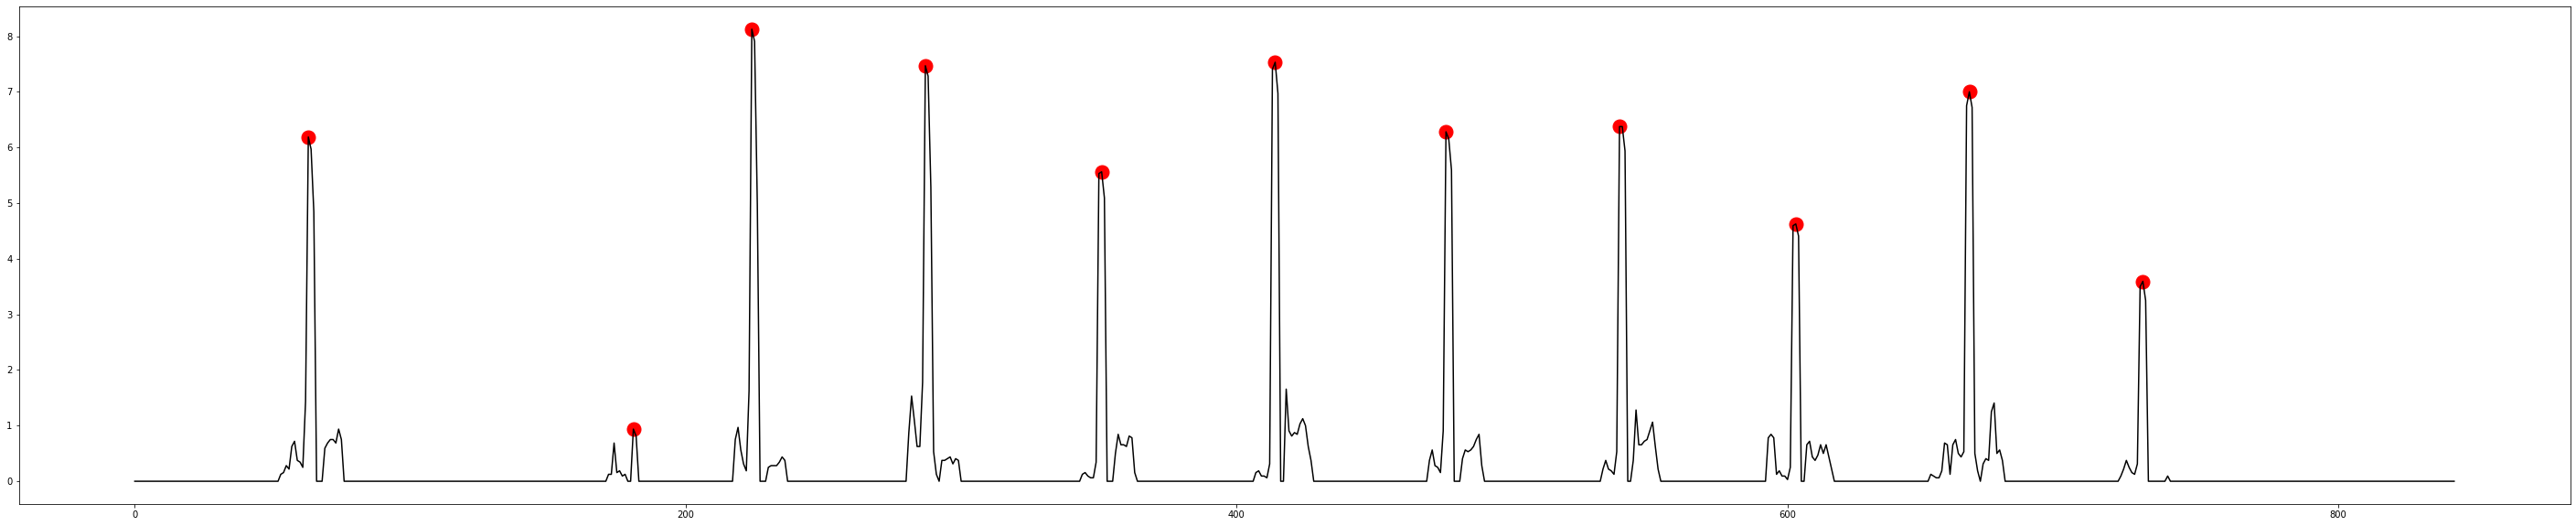

In [9]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

In [10]:
(unique, counts) = np.unique(sheet[2].thresh, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     0, 474461],
       [   255,  27371]])

In [11]:
def plot_page(page, ratio=kRatio):
  import matplotlib.pyplot as plt
  import matplotlib.patches as patches

  # Create figure and axes
  fig, ax = plt.subplots(figsize=(page.height / 10, page.width / 10))

  # Display the image
  ax.imshow(page.image)

  # Create a Rectangle patch
  max_x, max_y = 0, 0
  for index, (x, y, w, h, a) in enumerate(page.ccs):
    if w / h < ratio:
      continue
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)
    print(f'index={index}, w={w}, h={h}')
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=f'{index}')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2.0
    cy = ry + rect.get_height() / 2.0
    ax.annotate(f'{index}', (cx, cy), color='green', weight='bold', fontsize=16, ha='center', va='center')

  print(max_x)
  print(max_y)
  plt.show()

index=13, w=25, h=8
index=34, w=31, h=3
index=35, w=31, h=3
index=37, w=32, h=3
index=38, w=31, h=3
index=39, w=31, h=3
index=40, w=32, h=3
index=46, w=35, h=10
index=47, w=28, h=7
index=99, w=25, h=8
index=112, w=31, h=9
index=124, w=32, h=4
index=125, w=32, h=4
index=126, w=35, h=4
index=127, w=31, h=3
index=129, w=31, h=3
index=130, w=32, h=4
index=133, w=31, h=7
index=134, w=35, h=10
index=135, w=32, h=7
index=181, w=25, h=8
index=193, w=31, h=9
index=194, w=31, h=9
index=196, w=32, h=8
index=206, w=31, h=4
index=207, w=36, h=4
index=209, w=31, h=4
index=213, w=31, h=8
index=214, w=35, h=11
index=218, w=31, h=7
index=269, w=31, h=10
index=279, w=31, h=9
index=282, w=32, h=4
index=283, w=32, h=4
index=284, w=32, h=4
index=286, w=31, h=4
index=287, w=31, h=4
index=288, w=32, h=4
index=291, w=35, h=10
index=295, w=27, h=8
index=343, w=26, h=8
index=344, w=25, h=8
index=357, w=10, h=3
index=358, w=31, h=9
index=359, w=31, h=9
index=366, w=42, h=10
index=372, w=35, h=3
index=373, w=36, 

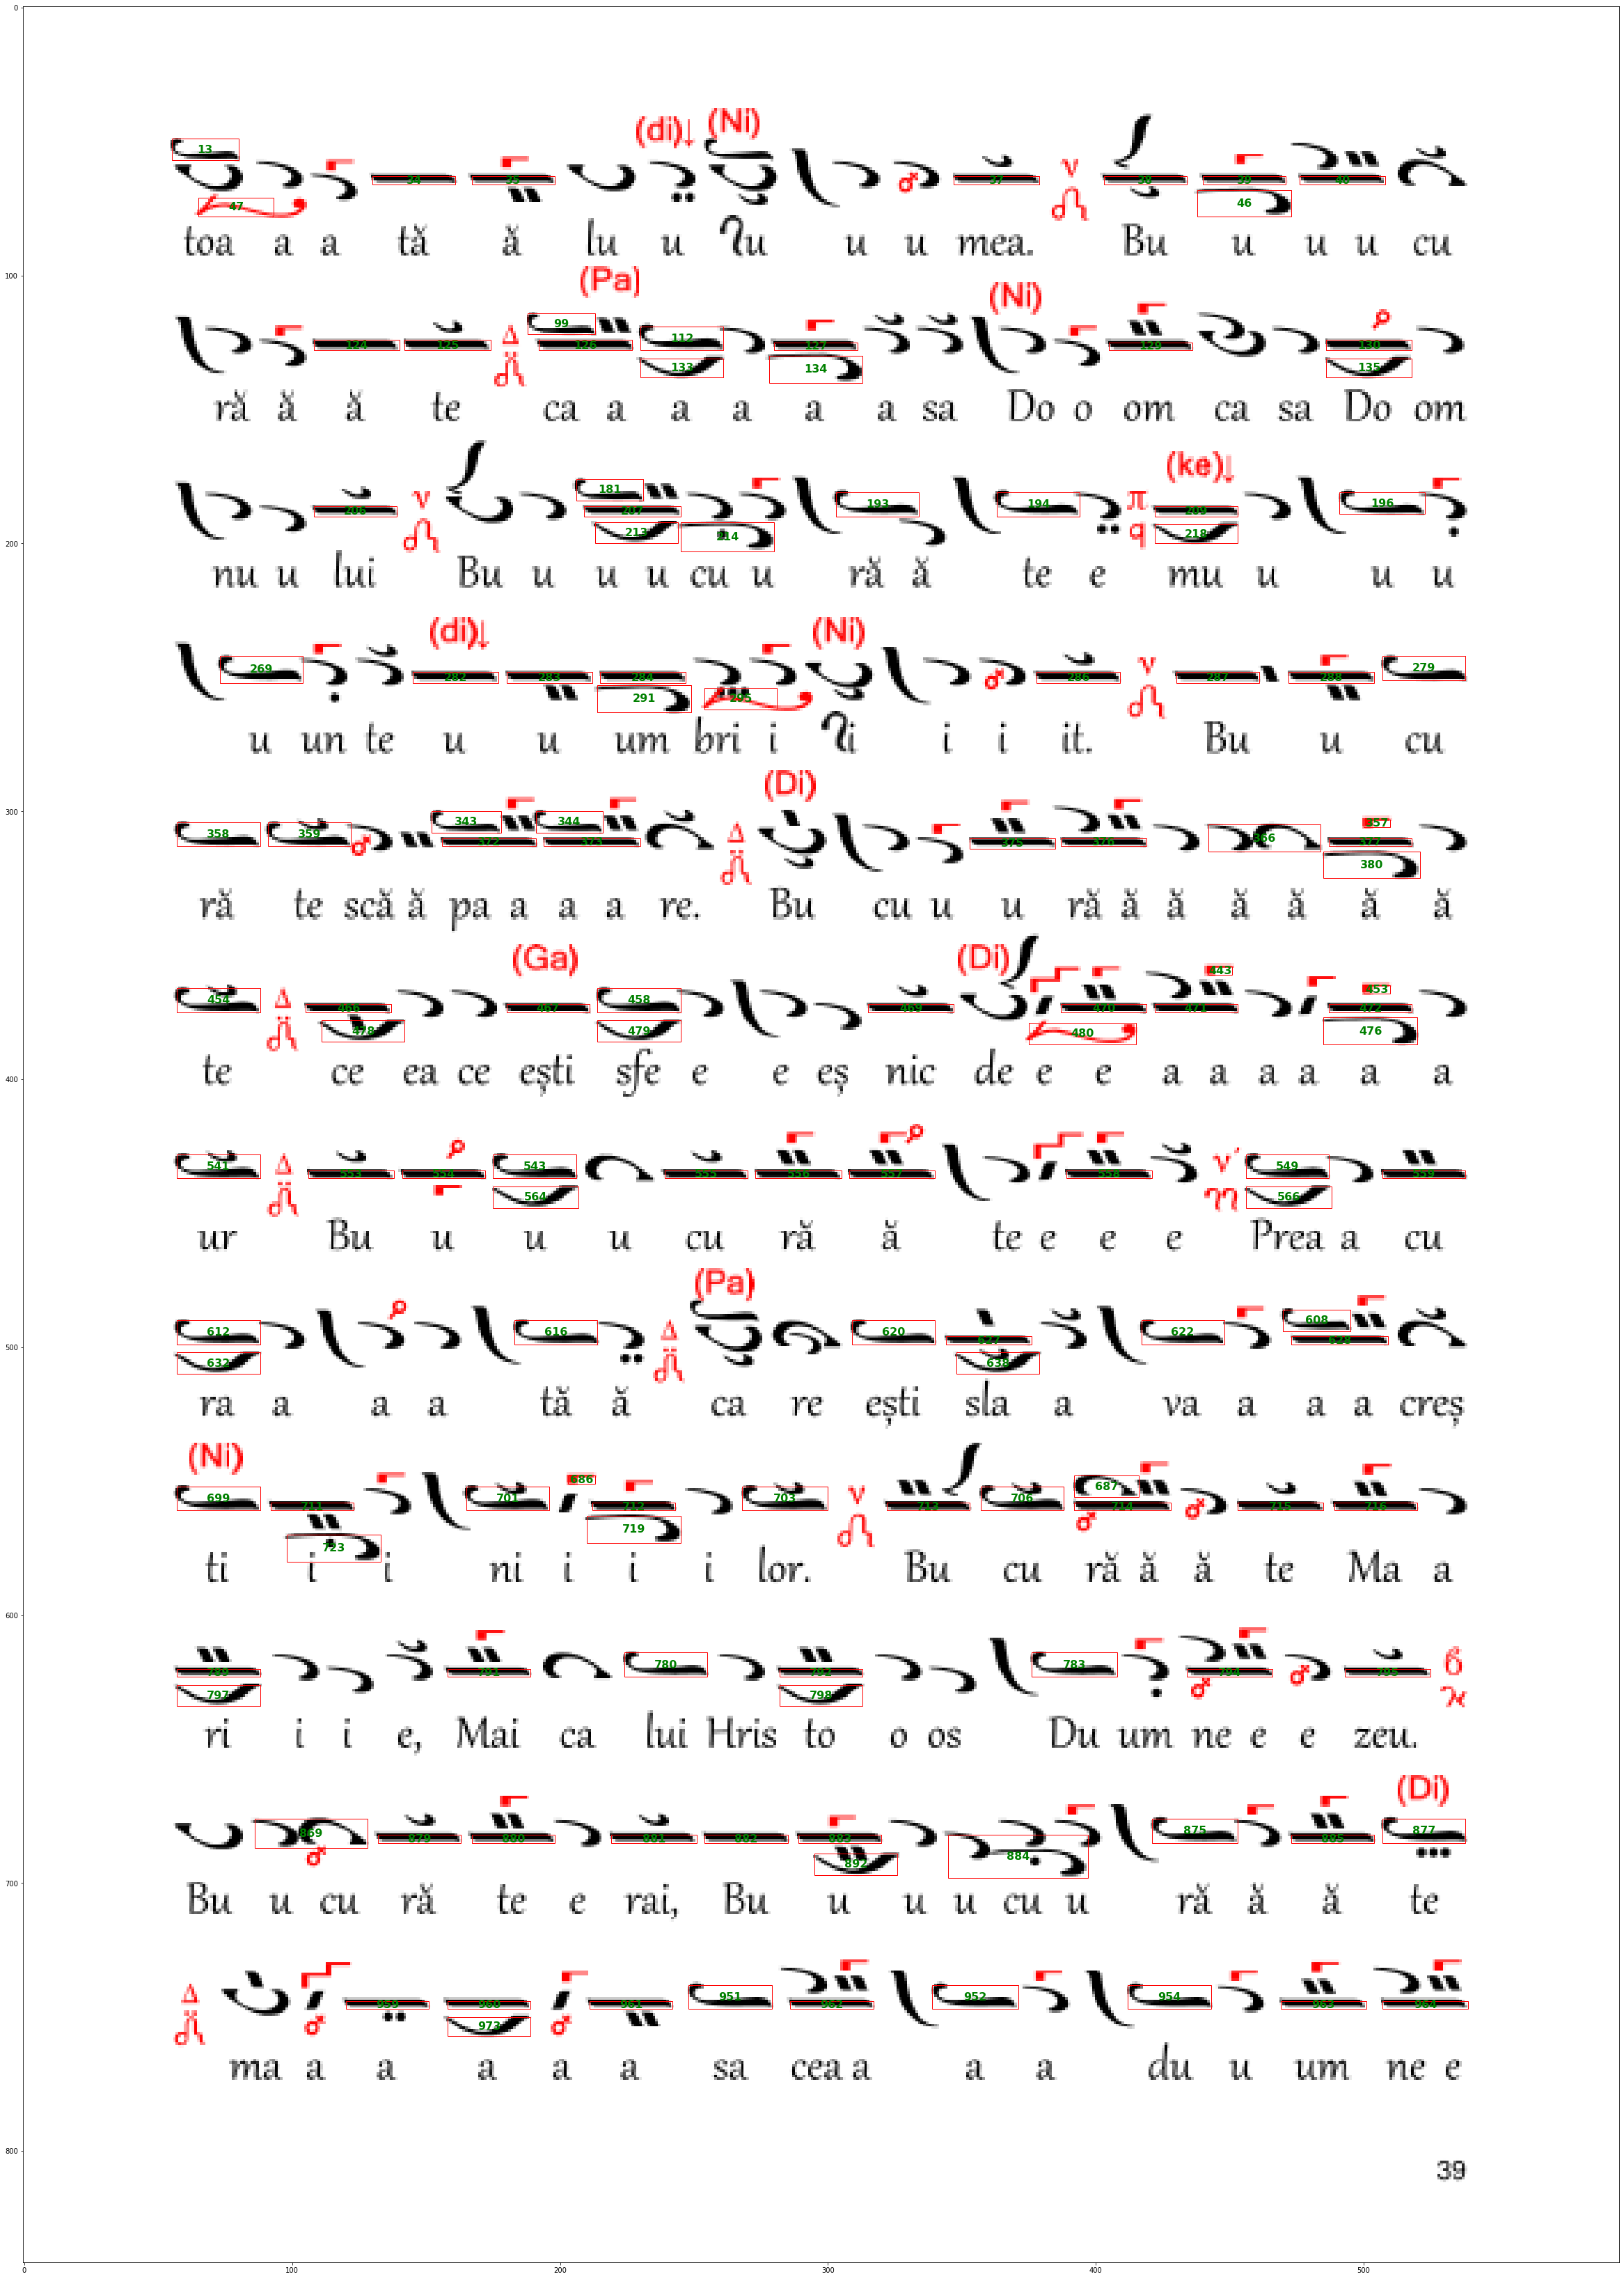

In [12]:
plot_page(sheet[38])